In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from collections import Counter

# from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score

In [4]:
data_path = 'D:\DATA\PracticeData'
data_type = {'code': 'object', 'nutrition_grade_fr': 'category', 'energy_100g': 'float64', }
df = pd.read_csv(os.path.join(data_path, 'openfoodfacts_processed.gz'), \
                 dtype=data_type, compression='gzip')
df.shape

(559935, 25)

In [5]:
df2 = df[df.nutrition_grade_fr.notna()]
df2.fiber_100g.fillna(value=0, inplace=True)
df2.shape

C:\Users\davilaYuan\Miniconda3\envs\sklearn\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(146356, 25)

In [6]:
# get the index with a string in the cell of a column
def get_category(string, column, dataframe): 
    idx_list = []
    for idx, row in dataframe.iterrows():
        if row[column] is not np.nan and string in row[column]:
            idx_list.append(idx)
    return idx_list

# Estimate Cocoa content

In [105]:
chocos = get_category('en:chocolates', 'categories_tags', df)
len(chocos)

5795

In [106]:
df_cc = df.iloc[chocos, :].drop(['alcohol_100g', 'energy-from-fat_100g', 'trans-fat_100g', \
                                 'cholesterol_100g', 'caffeine_100g', 'additives_tags', 'countries_tags', \
                                 'product_name', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'], axis=1)
df_cc.fiber_100g.fillna(0, inplace=True)
df_cc.additives_n.fillna(0, inplace=True)
df_cc.reset_index(inplace=True, drop=True)

In [107]:
not_used_cc = ['code', 'labels_tags', 'categories_tags', 'nutrition_grade_fr']
df_cc.drop(not_used_cc, axis=1).head()

,additives_n,energy_100g,fat_100g,fiber_100g,proteins_100g,sugars_100g,sodium_100g,salt_100g,cocoa_100g,saturated-fat_100g,carbohydrates_100g
0,1.0,537.0,32.5,1.7,6.8,53.5,0.078740,0.200,NaN,20.1,53.7
1,0.0,517.0,29.3,0.0,6.1,56.1,0.070866,0.180,30.0,18.1,56.4
2,0.0,361.0,11.5,29.5,25.8,1.2,0.000000,0.000,NaN,6.9,23.9
3,0.0,525.0,31.8,0.0,6.2,48.4,0.048819,0.124,NaN,19.6,50.2
4,2.0,574.0,40.0,2.5,5.0,50.0,0.087500,0.222,NaN,25.0,50.0


In [108]:
sum(df_cc.cocoa_100g.notna()), sum(df_cc.cocoa_100g.notna()) / df_cc.shape[0] * 100
# only half of all chocolate has value for cocoa content

(3072, 53.01121656600518)

In [220]:
df[df.code == '7862109270080']

,code,product_name,labels_tags,countries_tags,categories_tags,additives_n,additives_tags,energy_100g,fat_100g,fiber_100g,...,caffeine_100g,cocoa_100g,energy-from-fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_fr
503965,7862109270080,Choc. cru Pacari 100% Cacao,"en:organic,en:eu-organic,en:non-eu-agriculture...",en:france,"en:sugary-snacks,en:chocolates,en:dark-chocolates",0.0,NaN,735.0,71.0,NaN,...,NaN,100.0,NaN,41.0,NaN,NaN,7.0,19.0,19.0,e


In [109]:
cocoa = df_cc.cocoa_100g[df_cc.cocoa_100g.notna()]
energie = df_cc.energy_100g[df_cc.cocoa_100g.notna()]

In [165]:
df_cc_energy = df_cc[df_cc.cocoa_100g.notna()][['cocoa_100g', 'energy_100g']]
df_cc_energy.reset_index(inplace=True, drop=True)

In [166]:
df_cc_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 2 columns):
cocoa_100g     3072 non-null float64
energy_100g    3072 non-null float64
dtypes: float64(2)
memory usage: 48.1 KB


In [190]:
# get the categories on cocoa
df_cc_energy['cocoa_50cat'] = pd.cut(df_cc_energy.cocoa_100g, 50)
# group by cocoa, count cocoa_100g and mean on energy_100g
tmp = df_cc_energy.groupby(by='cocoa_50cat').agg({'cocoa_100g': 'count', 'energy_100g': 'mean'})
# tmp.fillna(0, inplace=True)
tmp.head()

,cocoa_100g,energy_100g
cocoa_50cat,,
"(-0.1, 2.0]",14,532.642857
"(2.0, 4.0]",0,NaN
"(4.0, 6.0]",0,NaN
"(6.0, 8.0]",0,NaN
"(8.0, 10.0]",1,560.000000


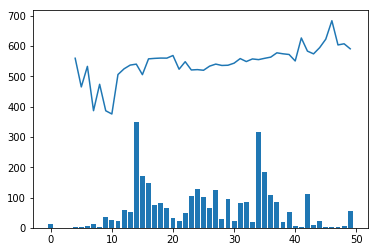

In [192]:
plt.bar(x=range(50), height=tmp.cocoa_100g)
plt.plot(range(50), tmp.energy_100g)
plt.show()

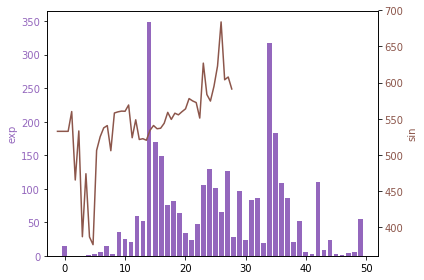

In [223]:
fig, ax1 = plt.subplots()

bar_color = 'tab:purple'
ax1.set_ylabel('exp', color=bar_color)
ax1.bar(x=range(50), height=tmp.cocoa_100g, color=bar_color)
ax1.tick_params(axis='y', labelcolor=bar_color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

line_color = 'tab:brown'
ax2.set_ylabel('sin', color=line_color)  # we already handled the x-label with ax1
# ax2.plot(range(50), tmp.energy_100g, color=line_color)
ax2.plot(range(50), tmp.energy_100g.fillna(method='ffill'), color=line_color)

ax2.tick_params(axis='y', labelcolor=line_color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

https://matplotlib.org/gallery/api/two_scales.html

In [193]:
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

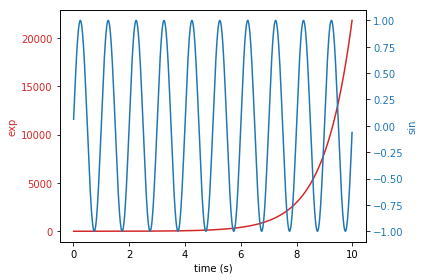

In [199]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color='tab:red')
ax1.plot(t, data1, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('sin', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(t, data2, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

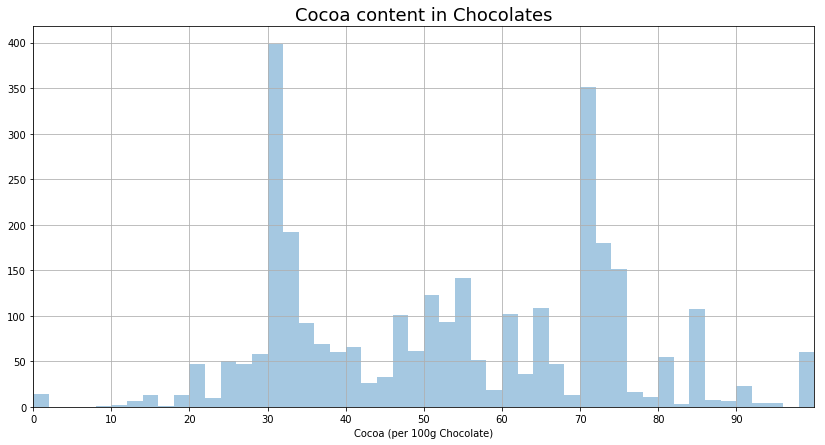

In [110]:
# sns.set()
plt.figure(figsize=(14, 7))
sns.distplot(cocoa, bins=50, kde=False)
plt.xlim(0, 100); plt.xticks(range(0, 100, 10))
plt.grid(True)
plt.title('Cocoa content in Chocolates', fontdict={'fontsize': 18})
plt.xlabel('Cocoa (per 100g Chocolate)')
# plt.savefig('fig07_cocoa.png', bbox_inches='tight', dpi=300)

plt.show()
# looks like bimodal, primary at 30% or 70%

In [111]:
# slicing dataframe for chocolates with cocoa content
df_cc = df_cc[df_cc.cocoa_100g.notna()]
df_cc['saturated-fat_100g'].fillna(0, inplace=True)
df_cc.shape

(3072, 15)

## With main nutrients

## With all avaiable nutrients

In [13]:
all_cols_cc = df_cc.drop(not_used_cc + ['cocoa_100g'], axis=1).columns

### with original data

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_cc[all_cols_cc], df_cc.cocoa_100g, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2457, 10), (615, 10), (2457,), (615,))

In [15]:
clfs = [LinearRegression(), Ridge(alpha=.001), Lasso(alpha=.001)]

for clf in clfs: 
    scores = cross_val_score(clf, df_cc[all_cols_cc], df_cc.cocoa_100g, cv=10)
    print(clf)
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print('--')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Accuracy: 0.6844 (+/- 0.0678)
--
Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Accuracy: 0.6845 (+/- 0.0678)
--
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Accuracy: 0.6845 (+/- 0.0678)
--


### with original + normalized

In [20]:
scaler = StandardScaler()
data = scaler.fit_transform(df_cc[all_cols_cc])
                            
X_train, X_test, y_train, y_test = \
    train_test_split(data, df_cc.cocoa_100g, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2457, 10), (615, 10), (2457,), (615,))

In [21]:
clfs = [LinearRegression(), Ridge(alpha=.001), Lasso(alpha=.001)]

for clf in clfs: 
    scores = cross_val_score(clf, data, df_cc.cocoa_100g, cv=10)
    print(clf)
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print('--')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Accuracy: 0.6844 (+/- 0.0678)
--
Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Accuracy: 0.6845 (+/- 0.0678)
--
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Accuracy: 0.6845 (+/- 0.0679)
--


### with polynomical features

In [68]:
poly = PolynomialFeatures(2)
data = poly.fit_transform(df_cc[all_cols_cc])
data.shape

(3072, 66)

In [69]:
X_train, X_test, y_train, y_test = \
    train_test_split(data, df_cc.cocoa_100g, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2457, 66), (615, 66), (2457,), (615,))

In [70]:
clfs = [LinearRegression(), Ridge(alpha=.1, max_iter=30000), Lasso(alpha=.1, max_iter=30000)]

for clf in clfs: 
    scores = cross_val_score(clf, data, df_cc.cocoa_100g, cv=10)
    print(clf)
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print('--')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Accuracy: -4.8641 (+/- 31.8285)
--
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=30000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Accuracy: 0.7787 (+/- 0.1277)
--


C:\Users\davilaYuan\Miniconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\davilaYuan\Miniconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=30000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Accuracy: 0.7853 (+/- 0.1209)
--


### with polynomial + normalized

##### with polynomical features

In [42]:
poly = PolynomialFeatures(2)
data = poly.fit_transform(df_cc[all_cols_cc])
data.shape

(3072, 66)

In [43]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
                            
X_train, X_test, y_train, y_test = \
    train_test_split(data, df_cc.cocoa_100g, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape     

((2457, 66), (615, 66), (2457,), (615,))

In [36]:
clfs = [LinearRegression(), Ridge(alpha=.1, max_iter=30000), Lasso(alpha=.1, max_iter=30000)]

for clf in clfs: 
    scores = cross_val_score(clf, data, df_cc.cocoa_100g, cv=10)
    print(clf)
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print('--')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Accuracy: -4.8598 (+/- 31.8023)
--
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=30000,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Accuracy: 0.7804 (+/- 0.1280)
--
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=30000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Accuracy: 0.7792 (+/- 0.0589)
--


### tuning the final modal

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
rig = Ridge(max_iter=50000)
las = Lasso(max_iter=50000)

In [40]:
params = {'alpha':[0.1, 0.5, 1.0, 3.0, 5.0], 'tol':[0.00001, 0.0001, 0.001, 0.01, 0.1]}

In [51]:
%%time
rig_cv = GridSearchCV(rig, params, cv=5)
rig_cv.fit(X_train, y_train)

Wall time: 646 ms


In [61]:
rig_cv.best_params_, rig_cv.best_score_

({'alpha': 3.0, 'tol': 1e-05}, 0.8199564155219551)

In [62]:
print(rig_cv.score(X_test, y_test))

0.7921610449891632


In [53]:
%%time
las_cv = GridSearchCV(las, params, cv=5)
las_cv.fit(X_train, y_train)

Wall time: 2.49 s


In [63]:
las_cv.best_params_, las_cv.best_score_

({'alpha': 0.1, 'tol': 0.001}, 0.7978377088863151)

In [64]:
print(las_cv.score(X_test, y_test))

0.7938065436999694


### correation between cocoa and other nutrients

In [49]:
corr_cols_cc = ['cocoa_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'carbohydrates_100g', \
                'fiber_100g', 'proteins_100g', 'sodium_100g', 'salt_100g', 'additives_n']

In [50]:
df_cc[corr_cols_cc].corr()

,cocoa_100g,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,carbohydrates_100g,fiber_100g,proteins_100g,sodium_100g,salt_100g,additives_n
cocoa_100g,1.000000,0.313682,0.635174,0.619289,-0.805047,-0.800799,0.257518,0.454399,-0.047743,-0.047745,-0.305609
energy_100g,0.313682,1.000000,0.783366,0.676025,-0.236885,-0.300936,-0.091567,0.284304,-0.056914,-0.056913,-0.192119
fat_100g,0.635174,0.783366,1.000000,0.875564,-0.673997,-0.737794,0.027820,0.423631,-0.023038,-0.023037,-0.272216
saturated-fat_100g,0.619289,0.676025,0.875564,1.000000,-0.601761,-0.656960,0.030593,0.307290,-0.011388,-0.011389,-0.252402
sugars_100g,-0.805047,-0.236885,-0.673997,-0.601761,1.000000,0.899188,-0.225002,-0.518119,0.020120,0.020121,0.237148
carbohydrates_100g,-0.800799,-0.300936,-0.737794,-0.656960,0.899188,1.000000,-0.203089,-0.539968,0.022274,0.022274,0.292901
fiber_100g,0.257518,-0.091567,0.027820,0.030593,-0.225002,-0.203089,1.000000,0.139015,-0.077451,-0.077458,-0.000582
proteins_100g,0.454399,0.284304,0.423631,0.307290,-0.518119,-0.539968,0.139015,1.000000,0.031477,0.031473,-0.226196
sodium_100g,-0.047743,-0.056914,-0.023038,-0.011388,0.020120,0.022274,-0.077451,0.031477,1.000000,1.000000,-0.022455
salt_100g,-0.047745,-0.056913,-0.023037,-0.011389,0.020121,0.022274,-0.077458,0.031473,1.000000,1.000000,-0.022454


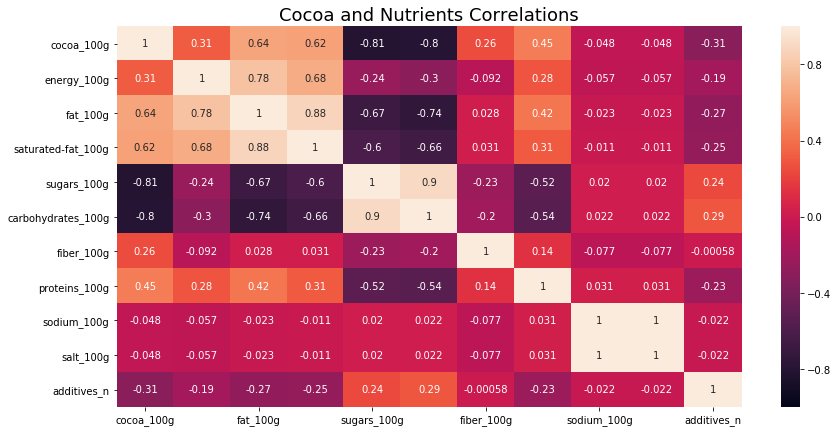

In [51]:
plt.figure(figsize=(14, 7))
sns.heatmap(df_cc[corr_cols_cc].corr(), xticklabels=2, annot=True, vmin=-1.0, vmax=1.0)
plt.title('Cocoa and Nutrients Correlations', fontdict={'fontsize': 18})
# plt.savefig('fig10_cocoa3.png', bbox_inches='tight', dpi=300)

plt.show()
# looks like bimodal, primary at 30% or 70%

### predict on the remaining chocolates

In [72]:
df_cc = df.iloc[chocos, :].drop(['alcohol_100g', 'energy-from-fat_100g', 'trans-fat_100g', \
                                 'cholesterol_100g', 'caffeine_100g', 'additives_tags', 'countries_tags', \
                                 'product_name', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'], axis=1)
df_cc.fiber_100g.fillna(0, inplace=True)
df_cc.additives_n.fillna(0, inplace=True)
df_cc.reset_index(inplace=True, drop=True)

In [73]:
not_used_cc = ['code', 'labels_tags', 'categories_tags', 'nutrition_grade_fr']
df_cc.drop(not_used_cc, axis=1).head()

,additives_n,energy_100g,fat_100g,fiber_100g,proteins_100g,sugars_100g,sodium_100g,salt_100g,cocoa_100g,saturated-fat_100g,carbohydrates_100g
0,1.0,537.0,32.5,1.7,6.8,53.5,0.078740,0.200,NaN,20.1,53.7
1,0.0,517.0,29.3,0.0,6.1,56.1,0.070866,0.180,30.0,18.1,56.4
2,0.0,361.0,11.5,29.5,25.8,1.2,0.000000,0.000,NaN,6.9,23.9
3,0.0,525.0,31.8,0.0,6.2,48.4,0.048819,0.124,NaN,19.6,50.2
4,2.0,574.0,40.0,2.5,5.0,50.0,0.087500,0.222,NaN,25.0,50.0


In [74]:
sum(df_cc.cocoa_100g.notna()), sum(df_cc.cocoa_100g.notna()) / df_cc.shape[0] * 100
# only half of all chocolate has value for cocoa content

(3072, 53.01121656600518)

In [79]:
tmp = df_cc[df_cc.cocoa_100g.isna()].drop(not_used_cc, axis=1)
tmp.head()

,additives_n,energy_100g,fat_100g,fiber_100g,proteins_100g,sugars_100g,sodium_100g,salt_100g,cocoa_100g,saturated-fat_100g,carbohydrates_100g
0,1.0,537.0,32.5,1.7,6.8,53.5,0.078740,0.200,NaN,20.1,53.7
2,0.0,361.0,11.5,29.5,25.8,1.2,0.000000,0.000,NaN,6.9,23.9
3,0.0,525.0,31.8,0.0,6.2,48.4,0.048819,0.124,NaN,19.6,50.2
4,2.0,574.0,40.0,2.5,5.0,50.0,0.087500,0.222,NaN,25.0,50.0
5,1.0,550.0,32.5,2.5,7.5,52.5,0.062500,0.159,NaN,20.0,55.0


In [90]:
tmp = tmp[(tmp.carbohydrates_100g.notna()) & (tmp['saturated-fat_100g'].notna())]

In [99]:
new_data = poly.transform(tmp[all_cols_cc] )
new_data = scaler.transform(new_data)
new_data.shape

(2717, 66)

In [100]:
new_label = las_cv.predict(new_data)

In [101]:
tmp.cocoa_100g = new_label

In [102]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2717 entries, 0 to 5794
Data columns (total 11 columns):
additives_n           2717 non-null float64
energy_100g           2717 non-null float64
fat_100g              2717 non-null float64
fiber_100g            2717 non-null float64
proteins_100g         2717 non-null float64
sugars_100g           2717 non-null float64
sodium_100g           2717 non-null float64
salt_100g             2717 non-null float64
cocoa_100g            2717 non-null float64
saturated-fat_100g    2717 non-null float64
carbohydrates_100g    2717 non-null float64
dtypes: float64(11)
memory usage: 254.7 KB


In [103]:
cocoa = tmp.cocoa_100g
energie = tmp.energy_100g

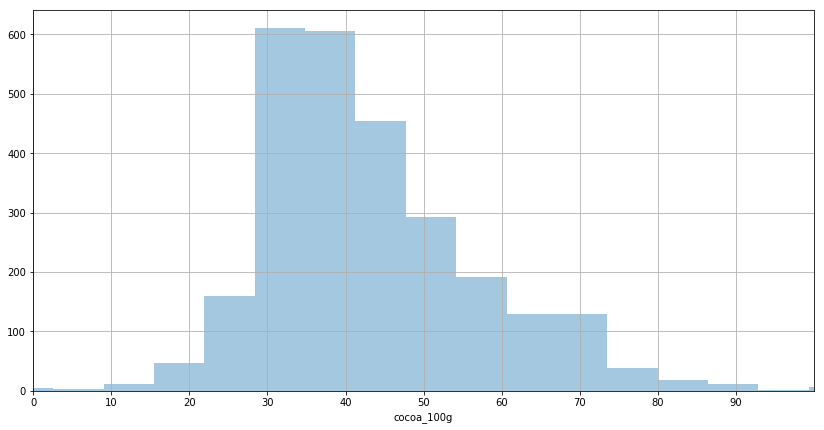

In [104]:
# sns.set()
plt.figure(figsize=(14, 7))
sns.distplot(cocoa, bins=50, kde=False)
plt.xlim(0, 100); plt.xticks(range(0, 100, 10))
plt.grid(True)
# plt.title('Cocoa content in Chocolates', fontdict={'fontsize': 18})
# plt.xlabel('Cocoa (per 100g Chocolate)')
# plt.savefig('cocoa.png', bbox_inches='tight', dpi=300)

plt.show()
# looks like bimodal, primary at 30% or 70%

In [71]:
df_cc.shape

(3072, 15)

In [ ]:
df_cc

# Binary Classifiers, on Healthy or Not-Healthy

In [18]:
used_cols_knn = ['code', 'additives_n', 'energy_100g', 'fat_100g', 'fiber_100g', 'proteins_100g', \
                'sugars_100g', 'sodium_100g', 'salt_100g', 'carbohydrates_100g', 'nutrition_grade_fr']
df_knn = df2[used_cols_knn]
df_knn = df_knn[df_knn.carbohydrates_100g.notna()]
df_knn.reset_index(inplace=True, drop=True)
df_knn.additives_n.fillna(0, inplace=True)
df_knn.shape

(146220, 11)

In [19]:
# set to 1 if rank is a or b, else 0; attribute: is_healthy
df_knn['is_healthy'] = df_knn.nutrition_grade_fr.apply(lambda x: 1 if x in ['a', 'b'] else 0)
df_knn.is_healthy = df_knn.is_healthy.astype('category')
df_knn.drop(['nutrition_grade_fr'], axis=1, inplace=True)
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146220 entries, 0 to 146219
Data columns (total 11 columns):
code                  146220 non-null object
additives_n           146220 non-null float64
energy_100g           146220 non-null float64
fat_100g              146220 non-null float64
fiber_100g            146220 non-null float64
proteins_100g         146220 non-null float64
sugars_100g           146220 non-null float64
sodium_100g           146220 non-null float64
salt_100g             146220 non-null float64
carbohydrates_100g    146220 non-null float64
is_healthy            146220 non-null category
dtypes: category(1), float64(9), object(1)
memory usage: 11.3+ MB


In [20]:
df_knn.is_healthy.value_counts()

0    105426
1     40794
Name: is_healthy, dtype: int64

In [21]:
df_knn.head()

,code,additives_n,energy_100g,fat_100g,fiber_100g,proteins_100g,sugars_100g,sodium_100g,salt_100g,carbohydrates_100g,is_healthy
0,0000000001281,0.0,381.0,22.0,4.4,4.6,21.9,0.039370,0.100,27.3,0
1,0000000001885,0.0,157.0,0.0,3.6,0.6,27.0,0.000000,0.000,36.0,1
2,0000000005241,0.0,197.0,5.0,0.0,8.4,3.0,0.183858,0.467,28.7,1
3,0000000005470,3.0,160.0,2.2,1.6,9.5,0.6,0.140945,0.358,25.2,1
4,0000000005661,0.0,253.0,17.0,0.0,23.0,0.5,0.984252,2.500,0.5,0


## Classify on the main nutrients

In [22]:
to_use_knn = ['energy_100g', 'fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

In [23]:
scaler = StandardScaler()
data = scaler.fit_transform(df_knn[to_use_knn])
data.shape

(146220, 6)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, df_knn.is_healthy, random_state=42, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((131598, 6), (14622, 6), (131598,), (14622,))

In [25]:
%%time
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.8572698673232116
Wall time: 484 ms


In [26]:
%%time
knn = KNeighborsClassifier(n_neighbors=5)
# knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9433046094925455
Wall time: 17.7 s


In [27]:
%%time
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(tree.score(X_test, y_test))

0.9379701819176584
Wall time: 744 ms


## Use all availble attributes

In [28]:
to_drop_knn = ['code', 'is_healthy']

## Evaluation metrics

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
# compute roc characteristics
from sklearn.metrics import roc_curve 
# compute the area under roc curve
from sklearn.metrics import auc

In [30]:
ranks = ['unhealthy', 'healthy']
lr_prd = lr.predict(X_test)
knn_prd = knn.predict(X_test)
tree_prd = tree.predict(X_test)

In [31]:
y_test.shape

(14622,)

### Logistic Regression Confusion Matrix

In [32]:
# specify label for order of labels
# cf_matrix = confusion_matrix(y_true=y_test, labels = [1, 0], y_pred=lr_prd)
cf_matrix = confusion_matrix(y_true=y_test, y_pred=lr_prd)
real_index = [['Real']*2, ranks]; pred_colum = [['Predicted']*2, ranks]
pd.DataFrame(cf_matrix, columns=pred_colum, index=real_index)

Predicted        
               unhealthy healthy
Real unhealthy      9461    1031
     healthy        1056    3074

In [33]:
precision_score(y_test, lr_prd), recall_score(y_test, lr_prd)

(0.74884287454324, 0.7443099273607748)

In [34]:
print(classification_report(y_true=y_test, y_pred=lr_prd))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     10492
           1       0.75      0.74      0.75      4130

   micro avg       0.86      0.86      0.86     14622
   macro avg       0.82      0.82      0.82     14622
weighted avg       0.86      0.86      0.86     14622



#### Logisitic Regresion ROC AUC 

In [35]:
# test_probs = lr.predict_proba(X_test)
test_probs = lr.predict_log_proba(X_test)
# test_probs = lr.decision_function(X_test)
test_probs.shape

(14622, 2)

In [36]:
y_score = test_probs[:, 1]
# y_score = test_probs
max(y_score), min(y_score)

(-1.7464030222111133e-11, -160.48673237967907)

In [37]:
lr_fpr, lr_tpr, threshold = roc_curve(y_test, y_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)

Area Under ROC Curve 0.9275686352521325


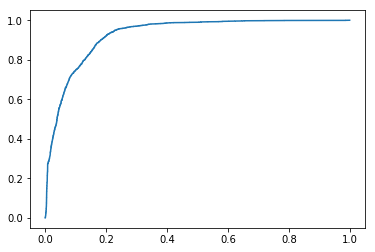

In [38]:
plt.plot(lr_fpr, lr_tpr)
print('Area Under ROC Curve', lr_roc_auc)

### KNN Confusion Matrix

In [39]:
ranks = ['unhealthy', 'healthy']
cf_matrix = confusion_matrix(y_true=y_test, y_pred=knn_prd) 
# same as:
# cf_matrix = confusion_matrix(y_true=y_test, labels = [0, 1], y_pred=knn_prd) 

real_index = [['Real']*2, ranks]; pred_colum = [['Predicted']*2, ranks]
pd.DataFrame(cf_matrix, columns=pred_colum, index=real_index)
# in the default setting, sklearn matrix order is [0, 1], i.e. [unhealthy, healthy]
# but the usuall representation is [1, 0], i.e. [True Case, False Case], or [Healthy, Not-Healthy]

Predicted        
               unhealthy healthy
Real unhealthy     10126     366
     healthy         463    3667

In [40]:
# with binary cases, these are: true_negative, false_positive, fasle_negative, true_positive
tn, fp, fn, tp = confusion_matrix(y_true=y_test, labels = [0, 1], y_pred=knn_prd).ravel()

In [41]:
# cf_matrix = confusion_matrix(y_true=y_test, y_pred=knn_prd)
ranks = ['healthy', 'unhealthy']
cf_matrix = confusion_matrix(y_true=y_test, labels = [1, 0], y_pred=knn_prd)
real_index = [['Real']*2, ranks]; pred_colum = [['Predicted']*2, ranks]
pd.DataFrame(cf_matrix, columns=pred_colum, index=real_index).transpose()

Real          
                    healthy unhealthy
Predicted healthy      3667       366
          unhealthy     463     10126

In [42]:
precision_score(y_test, knn_prd), recall_score(y_test, knn_prd)

(0.9092486982395239, 0.8878934624697337)

In [43]:
print(classification_report(y_true=y_test, y_pred=knn_prd))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10492
           1       0.91      0.89      0.90      4130

   micro avg       0.94      0.94      0.94     14622
   macro avg       0.93      0.93      0.93     14622
weighted avg       0.94      0.94      0.94     14622



#### KNN ROC AUC Curve
https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci

In [44]:
test_probs = knn.predict_proba(X_test)
test_probs.shape
# the return matrix has 2 columns, i.e. [predict as 0, predict as 1]
# we need prediction for positive case

(14622, 2)

In [45]:
y_score = test_probs[:, 1]
max(y_score), min(y_score)
# since it's KNN predict probability, it's either 1 or 0, by distance function

(1.0, 0.0)

In [46]:
knn_fpr, knn_tpr, threshold = roc_curve(y_test, y_score)
knn_roc_auc = auc(knn_fpr, knn_tpr)

Area Under ROC Curve 0.9710421130269667


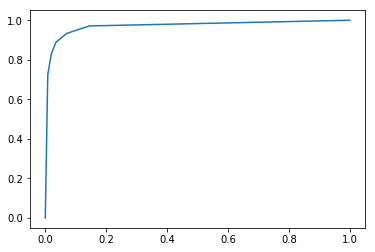

In [47]:
sns.lineplot(x=knn_fpr, y=knn_tpr)
print('Area Under ROC Curve', knn_roc_auc)

## Decision Tree Confusion Matrix

In [48]:
cf_matrix = confusion_matrix(y_true=y_test, y_pred=tree_prd)
real_index = [['Real']*2, ranks]; pred_colum = [['Predicted']*2, ranks]
pd.DataFrame(cf_matrix, columns=pred_colum, index=real_index)

Predicted          
                 healthy unhealthy
Real healthy       10040       452
     unhealthy       455      3675

In [49]:
precision_score(y_test, tree_prd), recall_score(y_test, tree_prd)

(0.8904773443179065, 0.8898305084745762)

In [50]:
print(classification_report(y_true=y_test, y_pred=tree_prd))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10492
           1       0.89      0.89      0.89      4130

   micro avg       0.94      0.94      0.94     14622
   macro avg       0.92      0.92      0.92     14622
weighted avg       0.94      0.94      0.94     14622



### Decision Tree ROC AUC Curve

In [51]:
test_probs = tree.predict_proba(X_test)
# test_probs = tree.predict_log_proba(X_test)
test_probs.shape

(14622, 2)

In [52]:
y_score = test_probs[:, 1]
max(y_score), min(y_score)

(1.0, 0.0)

In [53]:
tree_fpr, tree_tpr, threshold = roc_curve(y_test, y_score)
tree_roc_auc = auc(tree_fpr, tree_tpr)

C:\Users\davilaYuan\Miniconda3\envs\sklearn\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Area Under ROC Curve 0.9250148389318186


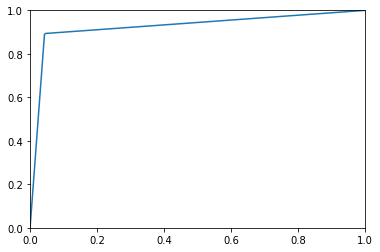

In [54]:
# plt.plot(fpr, tpr)
sns.lineplot(tree_fpr, tree_tpr)
plt.xlim([0, 1]); plt.ylim([0, 1])
print('Area Under ROC Curve', tree_roc_auc)

In [55]:
sns.set()

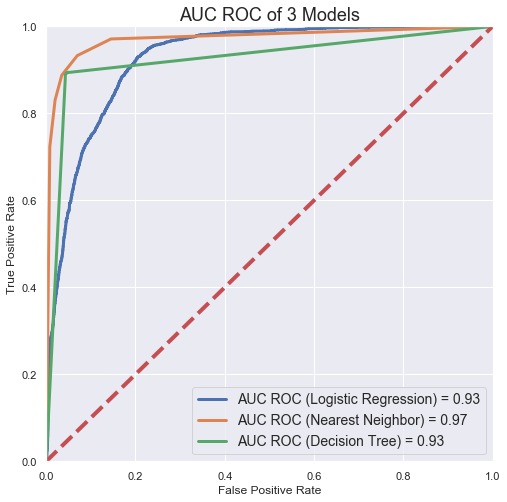

In [56]:
plt.figure(figsize=(8, 8))
plt.plot(lr_fpr, lr_tpr, lw=3, label='AUC ROC (Logistic Regression) = %0.2f' % lr_roc_auc)
plt.plot(knn_fpr, knn_tpr, lw=3, label='AUC ROC (Nearest Neighbor) = %0.2f' % knn_roc_auc)
plt.plot(tree_fpr, tree_tpr, lw=3, label='AUC ROC (Decision Tree) = %0.2f' % tree_roc_auc)
plt.plot([0, 1], [0, 1], '--', lw=4)

plt.legend(loc='lower right', fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('AUC ROC of 3 Models', fontdict={'fontsize': 18})
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('fig11_aucroc.png', bbox_inches='tight', dpi=300)

plt.show()

In [275]:
to_use_knn = ['energy_100g', 'fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

In [276]:
df3 = df[df.nutrition_grade_fr.isna()]
df3 = df3[to_use_knn]
df3.reset_index(inplace=True, drop=True)
df3.fiber_100g.fillna(0, inplace=True)
df3.shape

(413579, 6)

In [278]:
new_data = scaler.transform(df3)
new_data.shape

(413579, 6)

In [279]:
df3_pred = knn.predict(new_data)

In [281]:
np.bincount(df3_pred)

array([310352, 103227], dtype=int64)

## Estimate Calorie of Alcohol



In [298]:
df_al = pd.read_csv(os.path.join(data_path, 'openfoodfacts_alcohol.gz'), \
                 dtype=data_type, compression='gzip')
df_al.shape

(6592, 12)

In [301]:
df_al.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 12 columns):
code                  6592 non-null object
quantity              5882 non-null object
categories_tags       6483 non-null object
energy_100g           781 non-null float64
fat_100g              639 non-null float64
fiber_100g            259 non-null float64
carbohydrates_100g    671 non-null float64
proteins_100g         655 non-null float64
salt_100g             586 non-null float64
sodium_100g           586 non-null float64
sugars_100g           629 non-null float64
alcohol_100g          4659 non-null float64
dtypes: float64(9), object(3)
memory usage: 618.1+ KB


In [302]:
df_al.head()

,code,quantity,categories_tags,energy_100g,fat_100g,fiber_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,alcohol_100g
0,3257981230651,70 cl,"en:beverages,en:alcoholic-beverages,en:liqueur...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0
1,87120332,50 cl e,"en:beverages,en:alcoholic-beverages,en:beers,e...",173.0,0.0,NaN,3.1,0.0,0.01,0.003937,0.0,5.0
2,8001666753059,75cl,"en:beverages,en:alcoholic-beverages,en:wines,e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
3,3185370000038,1500 ml,"en:beverages,en:alcoholic-beverages,en:wines,e...",356.0,0.0,0.0,2.8,0.3,0.00,0.000000,1.4,12.0
4,3185370000397,750 ml,"en:beverages,en:alcoholic-beverages,en:wines,e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [309]:
df_al[df_al.alcohol_100g.notna() & df_al.energy_100g.notna() & (df_al.alcohol_100g > 10)  ]

,code,quantity,categories_tags,energy_100g,fat_100g,fiber_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,sugars_100g,alcohol_100g
3,3185370000038,1500 ml,"en:beverages,en:alcoholic-beverages,en:wines,e...",356.0,0.00,0.0,2.80,0.30,0.000000,0.000000,1.40,12.0
7,3185370045169,750 ml,"en:beverages,en:alcoholic-beverages,en:wines,e...",356.0,0.00,0.0,2.80,0.30,0.000000,0.000000,1.40,12.0
17,3185370479339,2 bouteilles (1.5 L),"en:beverages,en:alcoholic-beverages,en:wines,e...",356.0,0.00,0.0,2.80,0.30,0.000000,0.000000,1.40,12.0
26,5900343003148,70 cl,"en:beverages,en:alcoholic-beverages,en:hard-li...",4.0,1.00,NaN,1.00,100.00,0.000000,0.000000,1.00,40.0
289,4067700013859,0.7 l,"en:beverages,en:alcoholic-beverages",4.0,1.00,NaN,40.00,1.00,0.000000,0.000000,1.00,35.0
292,40677040,"0,04 l","en:beverages,en:alcoholic-beverages,en:liqueurs",4.0,1.00,NaN,1.00,1.00,NaN,NaN,1.00,35.0
316,4850088001828,"0,2 л",NaN,954.0,NaN,NaN,0.90,NaN,NaN,NaN,NaN,40.0
378,8002230130504,70 cl,"en:beverages,en:alcoholic-beverages,en:liqueurs",4.0,1.00,NaN,1.00,1.00,0.000000,0.000000,1.00,15.0
379,8002230130702,1 l,"en:beverages,en:alcoholic-beverages,en:liqueurs",0.0,0.00,0.0,0.00,0.00,0.000000,0.000000,0.00,15.0
380,2000000011741,50cl,"en:beverages,en:alcoholic-beverages,en:wines",636.0,0.00,0.0,11.70,0.20,2.286000,0.900000,1.10,15.6
